### OBSERVAR VIDEOS CON MEDIAPIPE

In [ ]:

import cv2
import mediapipe as mp
import os

# Iniciar MediaPipe
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
video_folder = r"./videos"
video_files = [f for f in os.listdir(video_folder)]

# Procesar cada video
for video_name in video_files:

    # Abrir el video
    video_path = os.path.join(video_folder, video_name)
    cap = cv2.VideoCapture(video_path)

    # Obtener cantidad de frames
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"Video: {video_name} - Total de frames: {total_frames}")

    # Configurar MediaPipe Hands
    with mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5) as hands:
        cv2.namedWindow("Procesando", cv2.WINDOW_AUTOSIZE)

        while cap.isOpened():
        
            # Extraer puntos mano
            _, frame = cap.read()
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = hands.process(frame_rgb)

            # Dibujar los landmarks
            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            frame_resized = cv2.resize(frame, (400, 300))
            cv2.imshow("Procesando", frame_resized)

            # Salir si se presiona 'q'
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    # Liberar
    cap.release()
    cv2.destroyAllWindows()

print("\n FIN.")


'\nimport cv2\nimport mediapipe as mp\nimport os\n\n# Iniciar MediaPipe\nmp_hands = mp.solutions.hands\nmp_drawing = mp.solutions.drawing_utils\nvideo_folder = r"C:/Users/Joshua Arango/Documents/Tesis/Código/Prueba/Nombre"\nvideo_files = [f for f in os.listdir(video_folder)]\n\n# Procesar cada video\nfor video_name in video_files:\n\n    # Abrir el video\n    video_path = os.path.join(video_folder, video_name)\n    cap = cv2.VideoCapture(video_path)\n\n    # Obtener cantidad de frames\n    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))\n    print(f"Video: {video_name} - Total de frames: {total_frames}")\n\n    # Configurar MediaPipe Hands\n    with mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5) as hands:\n        cv2.namedWindow("Procesando", cv2.WINDOW_AUTOSIZE)\n\n        while cap.isOpened():\n        \n            # Extraer puntos mano\n            _, frame = cap.read()\n            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)\n 

### LIBRERIAS Y ORB

In [ ]:

import numpy as np
import seaborn as sns
import mediapipe as mp
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Configuración de MediaPipe
mp_hands = mp.solutions.hands
mp_pose = mp.solutions.pose
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5)
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5)
max_frames = 90
num_keypoints = 21 


### EXTRACCIÓN DE CARACTERÍSTICAS

In [ ]:

# Extraer landmarks para un video
def extraer_puntos_clave_video(ruta_video):
    cap = cv2.VideoCapture(ruta_video)
    frames_puntos = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        resultado_pose = pose.process(frame_rgb)
        punto_torso = np.array([0.0, 0.0], dtype=np.float32)

        if resultado_pose.pose_landmarks:
            lms = resultado_pose.pose_landmarks.landmark
            hombro_izq = np.array([lms[11].x, lms[11].y])
            hombro_der = np.array([lms[12].x, lms[12].y])
            punto_torso = (hombro_izq + hombro_der) / 2
            escala = np.linalg.norm(hombro_der - hombro_izq)
        else:
            escala = 1.0

        resultado_hands = hands.process(frame_rgb)

        # Inicializar manos vacías
        mano_izquierda = np.zeros((num_keypoints, 2), dtype=np.float32)
        mano_derecha = np.zeros((num_keypoints, 2), dtype=np.float32)

        if resultado_hands.multi_hand_landmarks:
            for i, hand_landmarks in enumerate(resultado_hands.multi_hand_landmarks):
                if i < len(resultado_hands.multi_handedness):
                    mano = resultado_hands.multi_handedness[i].classification[0].label
                    puntos = np.array([[lm.x, lm.y] for lm in hand_landmarks.landmark], dtype=np.float32)
                    puntos -= punto_torso
                    puntos /= escala if escala > 1e-6 else 1.0

                    if mano == "Left":
                        mano_izquierda = puntos
                    elif mano == "Right":
                        mano_derecha = puntos

        # Concatenar siempre en el mismo orden: derecha, izquierda
        puntos = np.vstack([mano_derecha, mano_izquierda])
        frames_puntos.append(puntos.flatten())

    cap.release()
    return np.array(frames_puntos, dtype=np.float32)


# Procesar todos los videos en la carpeta
def procesar_videos(carpeta):
    datos, etiquetas = [], []
    clases = sorted(os.listdir(carpeta))

    for clase in clases:
        carpeta_clase = os.path.join(carpeta, clase)
        videos = [v for v in os.listdir(carpeta_clase)]

        for video in videos:
            ruta_video = os.path.join(carpeta_clase, video)
            puntos = extraer_puntos_clave_video(ruta_video)
            datos.append(puntos)
            etiquetas.append(clase)

    return np.array(datos, dtype=np.float32), np.array(etiquetas)


# One-hot encoding de etiquetas
def preprocesar_etiquetas(etiquetas):
    lb = LabelBinarizer()
    etiquetas_one_hot = lb.fit_transform(etiquetas)
    return etiquetas_one_hot, lb.classes_


# Carpetas de entrenamiento y prueba
carpeta_entrenamiento = r"./videos"
carpeta_prueba = r"./videos"

# Procesar datos
datos_entrenamiento, etiquetas_entrenamiento = procesar_videos(carpeta_entrenamiento)
datos_prueba, etiquetas_prueba = procesar_videos(carpeta_prueba)

# One-hot encoding
etiquetas_entrenamiento, clases = preprocesar_etiquetas(etiquetas_entrenamiento)
etiquetas_prueba, _ = preprocesar_etiquetas(etiquetas_prueba)

# Normalización por muestra
datos_entrenamiento /= np.max(np.abs(datos_entrenamiento), axis=(1, 2), keepdims=True)
datos_prueba /= np.max(np.abs(datos_prueba), axis=(1, 2), keepdims=True)


'\n# Extraer landmarks para un video\ndef extraer_puntos_clave_video(ruta_video):\n    cap = cv2.VideoCapture(ruta_video)\n    frames_puntos = []\n\n    while cap.isOpened():\n        ret, frame = cap.read()\n        if not ret:\n            break\n\n        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)\n        resultado_pose = pose.process(frame_rgb)\n        punto_torso = np.array([0.0, 0.0], dtype=np.float32)\n\n        if resultado_pose.pose_landmarks:\n            lms = resultado_pose.pose_landmarks.landmark\n            hombro_izq = np.array([lms[11].x, lms[11].y])\n            hombro_der = np.array([lms[12].x, lms[12].y])\n            punto_torso = (hombro_izq + hombro_der) / 2\n            escala = np.linalg.norm(hombro_der - hombro_izq)\n        else:\n            escala = 1.0\n\n        resultado_hands = hands.process(frame_rgb)\n\n        # Inicializar manos vacías\n        mano_izquierda = np.zeros((num_keypoints, 2), dtype=np.float32)\n        mano_derecha = np.zeros

### OBSERVAR FORMA DEL VECTOR

In [ ]:

index = 0  # Según el video que ver
puntos_guardados = datos_entrenamiento[index]
print(f"Forma del tensor: {puntos_guardados.shape}")  

# Verificar si hay información sobre el nombre del video
if isinstance(datos_entrenamiento, dict):  # Si los datos están en un diccionario con nombres de archivo
    video_name = list(datos_entrenamiento.keys())[index]
    print(f"Procesando video: {video_name}")
elif isinstance(datos_entrenamiento, list):  # Si los datos están en una lista
    print(f"Procesando video {index+1} de {len(datos_entrenamiento)}")

# Imprimir coordenadas de los primeros 5 frames
for i, frame in enumerate(puntos_guardados[:5]):  
    print(f"Frame {i+1}:\n{frame.squeeze()}")  


'\nindex = 0  # Según el video que ver\npuntos_guardados = datos_entrenamiento[index]\nprint(f"Forma del tensor: {puntos_guardados.shape}")  \n\n# Verificar si hay información sobre el nombre del video\nif isinstance(datos_entrenamiento, dict):  # Si los datos están en un diccionario con nombres de archivo\n    video_name = list(datos_entrenamiento.keys())[index]\n    print(f"Procesando video: {video_name}")\nelif isinstance(datos_entrenamiento, list):  # Si los datos están en una lista\n    print(f"Procesando video {index+1} de {len(datos_entrenamiento)}")\n\n# Imprimir coordenadas de los primeros 5 frames\nfor i, frame in enumerate(puntos_guardados[:5]):  \n    print(f"Frame {i+1}:\n{frame.squeeze()}")  \n'

### GUARDAR DATOS

In [ ]:

# Guardar datos de entrenamiento con nuevo nombre
np.savez("datos_entrenamientoPruZ.npz", datos=datos_entrenamiento, etiquetas=etiquetas_entrenamiento, clases=clases)

# Guardar datos de prueba con nuevo nombre
np.savez("datos_pruebaPruZ.npz", datos=datos_prueba, etiquetas=etiquetas_prueba)

print("Datos con puntos clave guardados correctamente.")


'\n# Guardar datos de entrenamiento con nuevo nombre\nnp.savez("datos_entrenamientoPruZ.npz", datos=datos_entrenamiento, etiquetas=etiquetas_entrenamiento, clases=clases)\n\n# Guardar datos de prueba con nuevo nombre\nnp.savez("datos_pruebaPruZ.npz", datos=datos_prueba, etiquetas=etiquetas_prueba)\n\nprint("Datos con puntos clave guardados correctamente.")\n'

### CARGAR DATOS

In [43]:
# Cargar datos de entrenamiento
datos_cargados = np.load("datos_entrenamientoPruZ.npz")
datos_entrenamiento = datos_cargados["datos"]
etiquetas_entrenamiento = datos_cargados["etiquetas"]
clases = datos_cargados["clases"]

# Cargar datos de prueba
datos_cargados = np.load("datos_pruebaPruZ.npz")
datos_prueba = datos_cargados["datos"]
etiquetas_prueba = datos_cargados["etiquetas"]

print("Datos cargados correctamente.")

Datos cargados correctamente.


### ENTRENAMIENTO DEL MODELO

In [54]:

modelo = Sequential([
    LSTM(64, return_sequences=True, input_shape=(max_frames, num_keypoints * 2 * 2)),
    BatchNormalization(),
    Dropout(0.5),
    LSTM(64),
    Dense(128, activation='relu'),
    Dense(len(clases), activation='softmax')
])

# Compilar el modelo
modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Configurar EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar el modelo
modelo.fit(
    datos_entrenamiento, etiquetas_entrenamiento, 
    epochs=80, batch_size=32, 
    callbacks=[early_stopping]
)

# Evaluación del modelo
puntuacion = modelo.evaluate(datos_prueba, etiquetas_prueba)
print("Pérdida:", puntuacion[0])
print("Precisión:", puntuacion[1])


c:\Users\Joshua Arango\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - accuracy: 0.1526 - loss: 2.2736
Epoch 2/80
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.2500 - loss: 2.0483

c:\Users\Joshua Arango\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.4008 - loss: 1.9786
Epoch 3/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.5744 - loss: 1.7265
Epoch 4/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.5944 - loss: 1.4491
Epoch 5/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.5559 - loss: 1.2752
Epoch 6/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - accuracy: 0.6853 - loss: 0.9947
Epoch 7/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.7006 - loss: 0.8719
Epoch 8/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.7616 - loss: 0.6754
Epoch 9/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.8295 - loss: 0.6056
Epoch 10/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.8164 - loss: 0.5298
Epoch 11/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.7443 - loss: 0.5850
Epoch 12/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.8281 - loss: 0.4124
Epoch 13/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.8777 - loss: 0.3826
Epoch 14/80

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 620ms/step


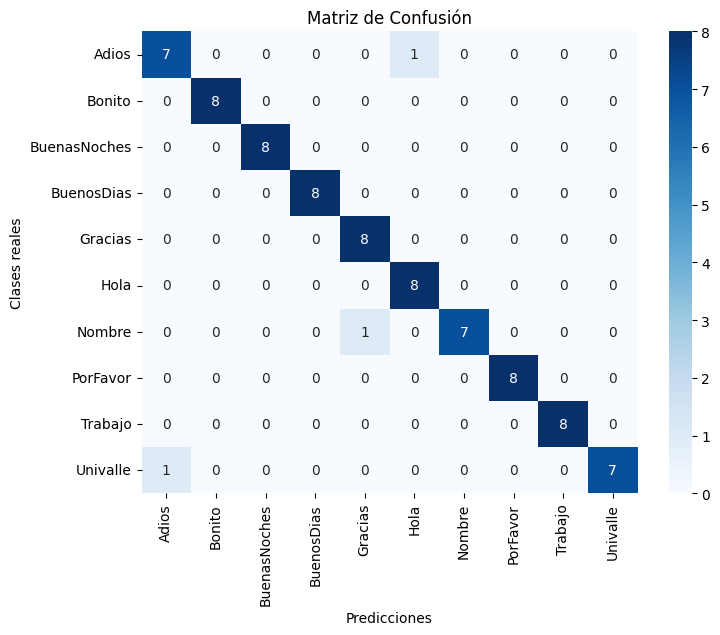

Reporte de clasificación:
              precision    recall  f1-score   support

       Adios       0.88      0.88      0.88         8
      Bonito       1.00      1.00      1.00         8
BuenasNoches       1.00      1.00      1.00         8
  BuenosDias       1.00      1.00      1.00         8
     Gracias       0.89      1.00      0.94         8
        Hola       0.89      1.00      0.94         8
      Nombre       1.00      0.88      0.93         8
    PorFavor       1.00      1.00      1.00         8
     Trabajo       1.00      1.00      1.00         8
    Univalle       1.00      0.88      0.93         8

    accuracy                           0.96        80
   macro avg       0.97      0.96      0.96        80
weighted avg       0.97      0.96      0.96        80



In [55]:

# Realizar predicciones
predicciones = modelo.predict(datos_prueba)
predicciones_clases = np.argmax(predicciones, axis=1)
etiquetas_reales = np.argmax(etiquetas_prueba, axis=1)

# Calcular matriz de confusión
matriz_confusion = confusion_matrix(etiquetas_reales, predicciones_clases)

# Visualizar la matriz de confusión
plt.figure(figsize=(8,6))
sns.heatmap(matriz_confusion, annot=True, fmt="d", cmap="Blues", xticklabels=clases, yticklabels=clases)
plt.xlabel("Predicciones")
plt.ylabel("Clases reales")
plt.title("Matriz de Confusión")
plt.show()

# Mostrar métricas adicionales
print("Reporte de clasificación:")
print(classification_report(etiquetas_reales, predicciones_clases, target_names=clases))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


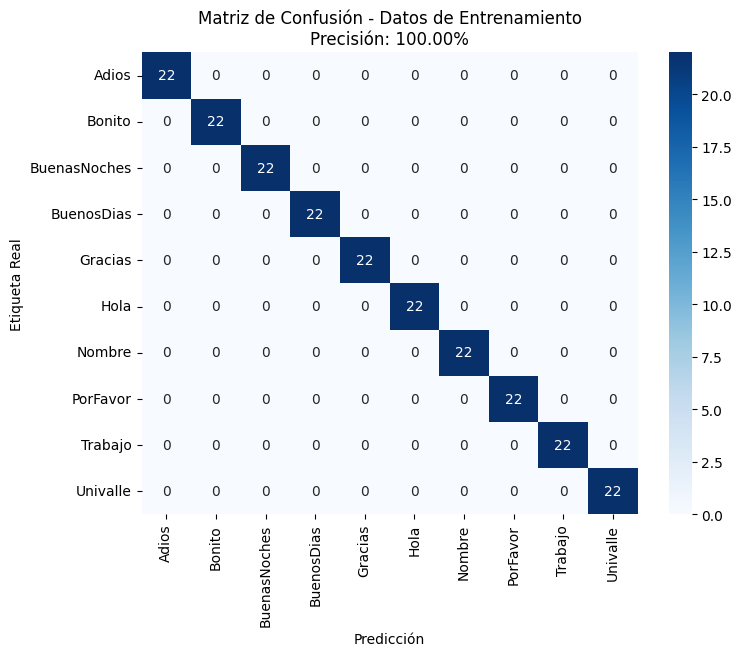

In [56]:

# Obtener predicciones del modelo en los datos de entrenamiento
y_pred_train_probs = modelo.predict(datos_entrenamiento)

# Convertir las probabilidades en etiquetas de clase
y_pred_train = np.argmax(y_pred_train_probs, axis=1)
y_true_train = np.argmax(etiquetas_entrenamiento, axis=1)

# Generar la matriz de confusión
conf_matrix_train = confusion_matrix(y_true_train, y_pred_train)

# Calcular precisión
accuracy_train = accuracy_score(y_true_train, y_pred_train)

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Blues", xticklabels=clases, yticklabels=clases)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.title(f"Matriz de Confusión - Datos de Entrenamiento\nPrecisión: {accuracy_train:.2%}")
plt.show()


In [3]:
modelo.save("modelo_gestosWowZ.h5")

NameError: name 'modelo' is not defined

### PRUEBA CON BASE DE DATOS EXTERNA

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Video: Adios1.mp4 | Real: Adios | Predicho: Trabajo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Video: Adios2.mp4 | Real: Adios | Predicho: Adios
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Video: Bonito1.mp4 | Real: Bonito | Predicho: Bonito
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Video: Bonito2.mp4 | Real: Bonito | Predicho: Bonito
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Video: BuenasNoches1.mp4 | Real: BuenasNoches | Predicho: BuenasNoches
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Video: BuenasNoches2.mp4 | Real: BuenasNoches | Predicho: BuenasNoches
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Video: BuenosDias1.mp4 | Real: BuenosDias | Predicho: BuenosDias
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Video: BuenosDias2.mp4 | Real: BuenosDias | Predicho: BuenosDias
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Video: Gracias1.mp4 | Real: Gracias | Predicho: Gracias
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Video: Gracias2.mp4 | Real: Gracias | Predicho: Nombre
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80

<Figure size 1000x800 with 0 Axes>

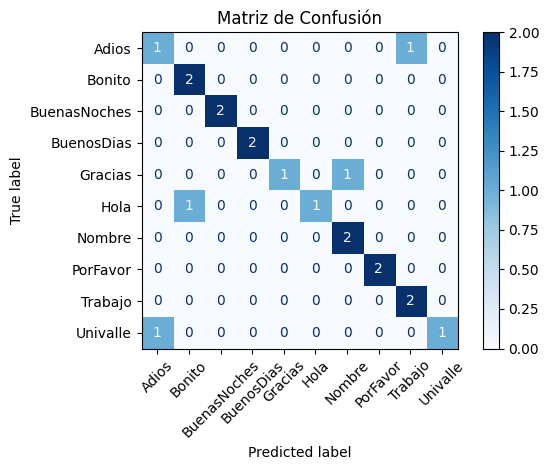

In [ ]:
import cv2
import os
import numpy as np
import tensorflow as tf
import mediapipe as mp
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Cargar modelo y clases
modelo = tf.keras.models.load_model("modelo_gestosWowz.h5")
clases = ["Adios", "Bonito", "BuenasNoches", "BuenosDias", "Gracias", "Hola", "Nombre", "PorFavor", "Trabajo", "Univalle"]

# Inicializar MediaPipe
mp_hands = mp.solutions.hands
mp_pose = mp.solutions.pose
hands = mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5)
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5)

max_frames = 90
num_keypoints = 21

# Carpeta de videos
carpeta_videos = r"./videos"
videos = [f for f in os.listdir(carpeta_videos)]

y_true = []
y_pred = []

for archivo in videos:

    ruta = os.path.join(carpeta_videos, archivo)
    cap = cv2.VideoCapture(ruta)

    if not cap.isOpened():

        print(f"Error al abrir el video: {archivo}")
        continue

    frames_puntos = []
    comenzado = False

    while cap.isOpened() and len(frames_puntos) < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        resultado_pose = pose.process(frame_rgb)
        resultado_hands = hands.process(frame_rgb)

        # Calcular torso y escala
        punto_torso = np.array([0.0, 0.0], dtype=np.float32)
        if resultado_pose.pose_landmarks:
            lms = resultado_pose.pose_landmarks.landmark
            hombro_izq = np.array([lms[11].x, lms[11].y])
            hombro_der = np.array([lms[12].x, lms[12].y])
            punto_torso = (hombro_izq + hombro_der) / 2
            escala = np.linalg.norm(hombro_der - hombro_izq)
            if escala < 1e-6:
                escala = 1.0
        else:
            escala = 1.0

        # Activar solo una vez cuando se detecte una mano
        if not comenzado and resultado_hands.multi_hand_landmarks:
            comenzado = True

        if comenzado:

            mano_izquierda = np.zeros((num_keypoints, 2), dtype=np.float32)
            mano_derecha = np.zeros((num_keypoints, 2), dtype=np.float32)

            if resultado_hands.multi_hand_landmarks:

                for i, hand_landmarks in enumerate(resultado_hands.multi_hand_landmarks):

                    if i < len(resultado_hands.multi_handedness):
                        
                        mano = resultado_hands.multi_handedness[i].classification[0].label
                        puntos = np.array([[lm.x, lm.y] for lm in hand_landmarks.landmark], dtype=np.float32)
                        puntos -= punto_torso
                        puntos /= escala

                        if mano == "Left":
                            mano_izquierda = puntos
                        elif mano == "Right":
                            mano_derecha = puntos

            # Concatenar derecha, luego izquierda (aunque sean ceros)
            puntos = np.vstack([mano_derecha, mano_izquierda])
            frames_puntos.append(puntos.flatten())

    cap.release()

    # Rellenar con ceros si faltan frames
    while len(frames_puntos) < max_frames:
        frames_puntos.append(np.zeros((num_keypoints * 2 * 2), dtype=np.float32))

    datos_video = np.array([frames_puntos], dtype=np.float32)
    datos_video /= np.max(datos_video, axis=(1, 2), keepdims=True) + 1e-6  # evitar división por cero

    prediccion = modelo.predict(datos_video)
    clase_predicha = clases[np.argmax(prediccion)]

    # Extraer clase real del nombre del archivo
    clase_real = os.path.splitext(archivo)[0]
    for clase in clases:
        if clase in clase_real:
            y_true.append(clase)
            break
    y_pred.append(clase_predicha)

    # Mostrar predicción
    print(f"Video: {archivo} | Real: {y_true[-1]} | Predicho: {clase_predicha}")



# Mostrar matriz de confusión
matriz = confusion_matrix(y_true, y_pred, labels=clases)
disp = ConfusionMatrixDisplay(confusion_matrix=matriz, display_labels=clases)
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.show()
